# Non-parametric estimation of the risk-neutral distribution for the SPX index from market data
**By Julian Ong** (zhunyong.research@gmail.com)

The risk-neutral distribution (RND) $g(S_T)$ of future asset prices $S_T$ at time $T$ expresses investor attitudes towards risk and  is reflected in the market pricing of options. The S&P 500 or SPX is a stock market index indicative of the health of the US economy. Thus, its RND is a powerful quantitative gauge of investor sentiments on the overall US economy.
I estimate the RND for the SPX, using the implied volatilities $\sigma(K_1)$, $\ldots$, $\sigma(K_N)$ at strike prices $K_1 < \ldots < K_N$ from its market data for options.
This estimation is based on the well-known *Breeden-Litzenberger* identity (1978),
$$
  g(S_T) = e^{rT} \left. \frac{\partial^2 C}{\partial K^2} \right|_{K=S_T}
$$
where $C$ denotes the call option price, and is implemented in Python using Numpy and Scipy.
The volatility smile is generated by interpolation from market data and smoothed by applying the Savitzky-Golay filter to ensure the convexity of $C$.
I estimate the distribution of expected returns from the RND and characterize its non-Gaussianity by computing its skewness and kurtosis.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
from scipy.stats import norm

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate

    Return:
    Black-Scholes value of call option (float)
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)

    return call_value

## Derivation of the Breeden-Litzenberger identity

The price of a European call options $C$ on an asset with strike price $K$ and maturity $T$ is given by
$$  
    C(K) = e^{rT} \int_{K}^{\infty} (S_T-K)g(S_T) dS_T
$$
where $r$ is the risk-free rate, $S_T$ is the asset price at time $T$, and $g$ is the risk-neutral distribution (RND) of $S_T$. Differentiating once with respect to $K$ yields
$$
    \frac{\partial C}{\partial K} = -e^{-rT} \int_{K}^{\infty} g(S_T) dS_T \ .
$$
Differentiating again with respect to $K$ yields
$$
    \frac{\partial^2 C}{\partial K^2} = e^{-rT} g(K) \ .
$$

This implies that the risk-neutral probability distribution is determined by the second derivative of $c(K,T)$, i.e.,
$$
g(S_T) = e^{rT} \left. \frac{\partial^2 C}{\partial K^2} \right|_{K=S_T}
$$
This identity implies that $C$ is strictly convex with respect to $K$ because $g(S_T) \geq 0$.
We note that in deriving this identity, we have not assumed anything about its functional form and $g(S_T)$ does not necessarily have to describe a log-normal distribution as assumed in the Black-Scholes model.  


The Breeden-Litzenberger identity suggests that we can estimate $g(S_T)$ from market data for call options, which is described by call option prices $C(K_1)$, $\ldots$, $C(K_N)$ at strike prices $K_1 < \ldots < K_N$.
In practice, because the market data for call option prices is noisy, it is easier to work with the implied volatilities and use them to estimate the call option prices.

## SPX call options

In this project, I investigate the risk-neutral distribution of the SPX index from the market data for its European call options.

The workflow to obtain the RND is as follows.

1. At a given time $T$ in the future, I extract the implied volatilities $\sigma(K_1)$, $\ldots$, $\sigma(K_N)$ at strike prices $K_1 < \ldots < K_N$ from the market data using the Yahoo Finance ('yfinance') module. The strike prices are however *not* uniformly distributed. For the purpose of illustrating the method, I use $T$ = 28 days.

2. I set up a dense uniformly distributed array of $K$ points ($K_1$, $K_1 + \delta$, $K_1 + 2\delta$, $\ldots$, where $\delta$ is the interval between strike prices) and calculate the implied volatility $\sigma(K)$ for each $K$, using a piecewise cubic spline interpolator. This gives us a dense $\sigma(K)$ array or the **entire volatility smile** over the $K$ array.

3. I smooth the volatility smile using the Savitzky-Golay filter in SciPy to reduce numerical noise.

4. I compute the corresponding call options price $C(K)$ array from the volatility smile using the classic Black-Scholes formula.

5. I compute the first and second derivatives of $C(K)$ numerically. Before taking the first derivative, I smooth the first derivative with the Savitzky-Golay filter. This reduces the noise in the second derivative.

In [ ]:
### I download the stock index and options data for the SPX

date_today = datetime.date.today().strftime("%Y-%m-%d") # today's date

stock_symbol = '^SPX' # S&P 500 index
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '2d', interval = '1d')
expirations = ticker.options

/tmp/ipykernel_3676629/1517656923.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '2d', interval = '1d')
[*********************100%***********************]  1 of 1 completed


In [ ]:
S0 = stock_data[('Close','^SPX')].iloc[-1] # current stock price at time 0
print(f"Current closing stock price for the SPX is S0 = ${S0: .2f}")


Current closing stock price for the SPX is S0 = $ 6822.34


In [ ]:
# Parameters for call options
days_to_expiry = 28 # we set the time to expiry
risk_free_rate = 0.01 # risk-free rate of 1 percent

date_start = datetime.datetime.strptime(date_today, "%Y-%m-%d")

for date in expirations:
    date_strike = datetime.datetime.strptime(date, "%Y-%m-%d") # expiry date

    time_difference = (date_strike-date_start).days # no. of days to expiry

    if time_difference >= days_to_expiry:
        t = time_difference/365.0 # time to expiry in years
        r = risk_free_rate

        chain = ticker.option_chain(date)
        # Add expiration and label
        calls = chain.calls.copy()
        calls['expiration'] = date
        calls['optionType'] = 'call'
        calls['currentDate'] = date_today
        # calls['averagePrice'] = 0.5*(calls['bid'] + calls['bid'])

        sigma = calls['impliedVolatility'].to_numpy() # implied volatility
        K = calls['strike'].to_numpy() # strike price
        impliedCallPrice = bs_call(S0, K, sigma, t, r) # BS call price
        calls['impliedPrice'] = impliedCallPrice # price for implied volatility

        break

print(f"We use the call option prices with {time_difference} days to expiry.")
print(f"Current date is {calls['currentDate'][0]}.")
print(f"The expiry date is {calls['expiration'][0]}.")


We use the call option prices with 28 days to expiry.
Current date is 2025-10-31.
The expiry date is 2025-11-28.


## Implied volatility from market data

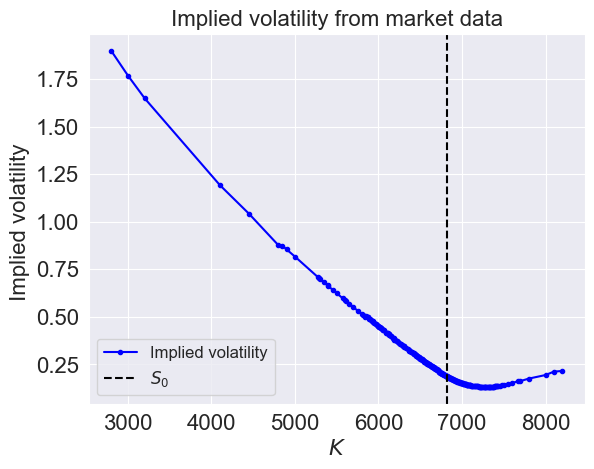

In [ ]:
calls = calls.drop(calls[calls['impliedVolatility'] < 1E-3].index)
K = calls['strike'].to_numpy().reshape(-1,1) # strike prices data
C = calls['impliedPrice'].to_numpy().reshape(-1,1) # call prices data
V = calls['impliedVolatility'].to_numpy().reshape(-1,1) # implied volatility data
n_calls = len(K)

# Plot volatility smile from call prices
plt.rcParams['axes.titlesize'] = 16  # Title font size
plt.rcParams['axes.labelsize'] = 16  # Axis label font size
plt.rcParams['xtick.labelsize'] = 16 # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 16 # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 12 # Legend font size
plt.plot(K,V,marker='.',linestyle='-',color='b',label='Implied volatility')
plt.axvline(S0,linestyle='--',color='k',label='$S_0$')
plt.xlabel('$K$ ')
plt.ylabel('Implied volatility ')
plt.title('Implied volatility from market data')
plt.legend()
plt.show()

## Computation of array of $K$ and $\sigma(K)$
We set up the uniform array of strike $K$ and implied volatility $\sigma(K)$ values by interpolating the market data for the implied volatility. After interpolation, the $\sigma(K)$ values are first smoothed by applying the Savitzky-Golay filter repeatedly to reduce the noise in the data. The post-processed $\sigma(K)$ values are then used to compute the Black-Scholes call option prices.

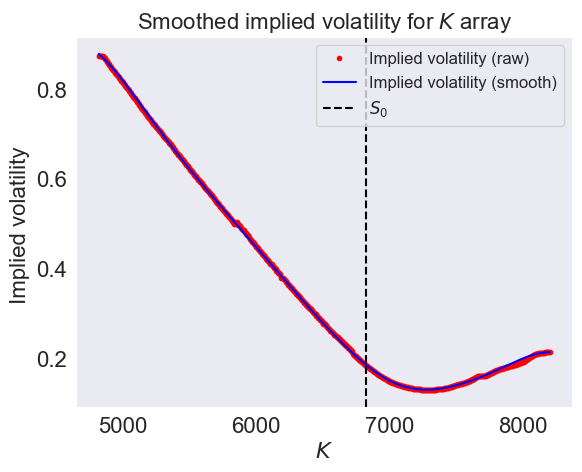

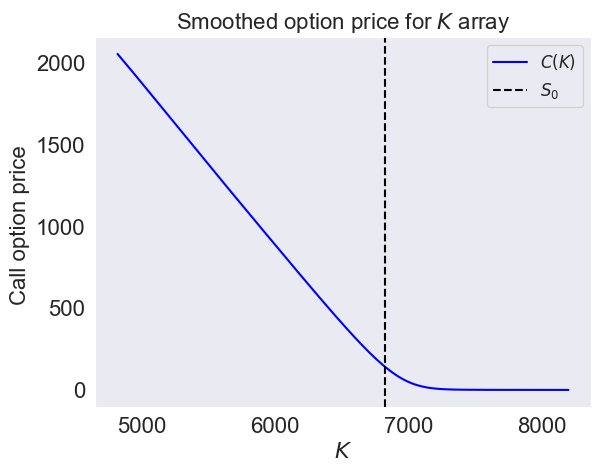

In [ ]:
from scipy.interpolate import PchipInterpolator
from scipy.signal import savgol_filter

window_param = 41 # window parameter for Savitzky-Golay filter smoothing

pci = PchipInterpolator(K.squeeze(),V.squeeze())
dK = 5 # spacing in strike prices
K_min = np.maximum( np.round((S0-2000)/dK)*dK, K[0].squeeze() )
K_max = np.minimum( np.round((S0+2000)/dK)*dK, K[-1].squeeze() )

K_grid = np.arange(K_min,K_max+dK,dK).reshape(-1,1) # Grid of K values

V_grid_raw = pci(K_grid) # implied volatility values over K grid
V_grid = pci(K_grid) # implied volatility values over K grid
for _ in range(500): # SG filtering of IV curve for 500 repetitions to eliminate noise
    V_grid = (savgol_filter(V_grid.squeeze(),window_param,3)).reshape(-1,1)
C_grid = bs_call(S0, K_grid, V_grid, t, r).reshape(-1,1) # Black-Scholes price from implied IV

plt.figure()
plt.plot(K_grid,V_grid_raw,marker='.',linestyle='none',
         color='r',label='Implied volatility (raw)')
plt.plot(K_grid,V_grid,marker='none',linestyle='-',
         color='b',label='Implied volatility (smooth)')
plt.axvline(S0,linestyle='--',color='k',label='$S_0$')
plt.xlabel('$K$ ')
plt.ylabel('Implied volatility ')
plt.legend()
plt.title('Smoothed implied volatility for $K$ array')
plt.grid()
plt.show()

plt.figure()
plt.plot(K_grid,C_grid,marker='none',linestyle='-',color='b',label='$C(K)$')
plt.axvline(S0,linestyle='--',color='k',label='$S_0$')
plt.xlabel('$K$ ')
plt.ylabel('Call option price ')
plt.legend()
plt.title('Smoothed option price for $K$ array')
plt.grid()
plt.show()


In [ ]:
# 1st derivatives of call options prices

dC_grid = np.gradient(C_grid.squeeze(),dK).reshape(-1,1) # first derivative of call price wrt K
dC_grid = (savgol_filter(dC_grid.squeeze(),window_param,3)).reshape(-1,1) # smoothen first derivative


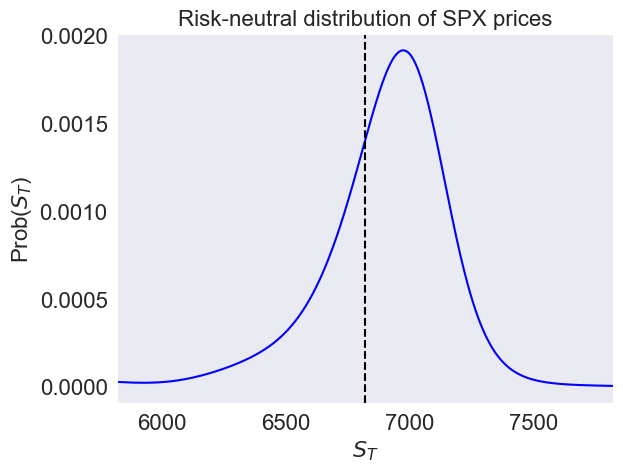

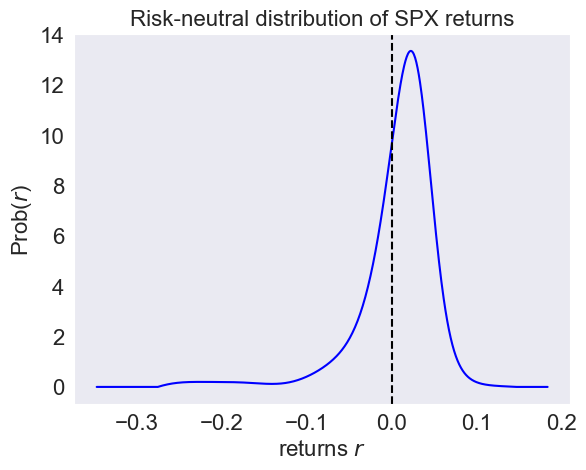

In [ ]:
# 2nd derivatives of call options prices

ddC_grid = np.gradient(dC_grid.squeeze(),dK).reshape(-1,1) # second derivative of call price

g_grid = np.exp(r*t)*ddC_grid
g_grid[g_grid<0] = 0 # remove spurious negative probability values

plt.plot(K_grid,g_grid,linestyle='-',color='b')
plt.axvline(S0,linestyle='--',color='k',label='$S_0$')
plt.xlabel('$S_T$ ')
plt.ylabel('Prob($S_T$) ')
plt.xlim([S0-1000,S0+1000])
plt.title('Risk-neutral distribution of SPX prices')
plt.grid()
plt.show()

r_grid = np.log(K_grid/S0) # returns
Pr_grid = g_grid*K_grid # probability of returns

plt.plot(r_grid,Pr_grid,linestyle='-',color='b')
plt.axvline(0,linestyle='--',color='k')
plt.xlabel('returns $r$')
plt.ylabel('Prob($r$) ')
plt.title('Risk-neutral distribution of SPX returns')
# plt.xlim([S0-1000,S0+1000])
plt.grid()
plt.show()



We check the normalization of the RND for the SPX index and its returns.

In [ ]:
total_prob_price = np.trapezoid(g_grid.squeeze(),K_grid.squeeze())
total_prob_return = np.trapezoid(Pr_grid.squeeze(),r_grid.squeeze())
print(f"The total probability for the RND of prices is {100*total_prob_price: .4f} percent.")
print(f"The total probability for the RND of returns is {100*total_prob_return: .4f} percent.")


The total probability for the RND of prices is  100.0202 percent.
The total probability for the RND of returns is  100.0202 percent.


## Moments of returns distribution

We compute the moments (mean, variance, skewness and kurtosis) for the risk-neutral distribution

In [ ]:
mean_rnd = np.trapezoid((Pr_grid*r_grid).squeeze(),r_grid.squeeze())
variance_rnd = np.trapezoid((Pr_grid*(r_grid-mean_rnd)**2).squeeze(),r_grid.squeeze())
skewness_rnd = np.trapezoid((Pr_grid*(r_grid-mean_rnd)**3).squeeze(),r_grid.squeeze())
kurtosis_rnd = np.trapezoid((Pr_grid*(r_grid-mean_rnd)**4).squeeze(),r_grid.squeeze())
print("Risk-neutral distribution")
print(f"The mean is {mean_rnd:.4e}.")
print(f"The variance is {variance_rnd:.4e}.")
print(f"The skewness is {skewness_rnd:.4e}.")
print(f"The kurtosis is {kurtosis_rnd:.4e}.")
print('--'*20)

Pr_gauss_grid = 1/np.sqrt(2*np.pi*variance_rnd)*np.exp(-(r_grid-0)**2/(2*variance_rnd))
mean_gauss = np.trapezoid((Pr_gauss_grid*r_grid).squeeze(),r_grid.squeeze())
variance_gauss = np.trapezoid((Pr_gauss_grid*(r_grid-mean_gauss)**2).squeeze(),r_grid.squeeze())
skewness_gauss = np.trapezoid((Pr_gauss_grid*(r_grid-mean_gauss)**3).squeeze(),r_grid.squeeze())
kurtosis_gauss = np.trapezoid((Pr_gauss_grid*(r_grid-mean_gauss)**4).squeeze(),r_grid.squeeze())
print("Normal distribution with same variance")
print(f"The mean is {mean_gauss:.4e}.")
print(f"The variance is {variance_gauss:.4e}.")
print(f"The skewness is {skewness_gauss:.4e}.")
print(f"The kurtosis is {kurtosis_gauss:.4e}.")

Risk-neutral distribution
The mean is 7.0715e-03.
The variance is 2.2828e-03.
The skewness is -2.4602e-04.
The kurtosis is 5.8718e-05.
----------------------------------------
Normal distribution with same variance
The mean is -1.1540e-05.
The variance is 2.2806e-03.
The skewness is -3.6408e-07.
The kurtosis is 1.5547e-05.


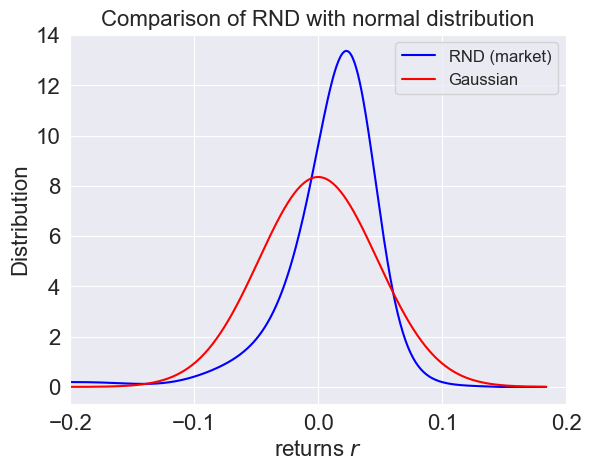

In [ ]:
plt.plot(r_grid,Pr_grid,linestyle='-',color='b',label='RND (market)')
plt.plot(r_grid,Pr_gauss_grid,linestyle='-',color='r',label='Gaussian')
plt.xlabel('returns $r$')
plt.ylabel('Distribution')
plt.title('Comparison of RND with normal distribution')
plt.xlim([-0.2,0.2])
plt.legend()
plt.show()